# Aircraft Accident Prediction Model
By Isa de Luis

This project focuses on developing a machine learning model to predict outcomes from aviation safety data, leveraging a Multi-Layer Perceptron (MLP) for classification. Using data preprocessed with techniques like frequency encoding, SMOTE for class balancing, and feature scaling, the model seeks to identify patterns and insights that contribute to aviation incidents. The project incorporates regularization, dropout, and batch normalization to address overfitting and optimize generalization. This initiative is aimed at enhancing aviation safety by improving the reliability and interpretability of predictive models, while carefully considering ethical implications like data fairness and transparency.

My motivation for this project stems from a deep commitment to improving aviation safety and preventing accidents. Having personally experienced the impact of a tragic aviation incident when my aunt died in the 737-8 MAX crash in Ethiopia, I have become acutely aware of the importance of rigorous safety measures and the role technology can play in preventing future tragedies. This project allows me to channel my passion for data-driven solutions into creating a tool that can identify critical factors contributing to aviation risks. By leveraging machine learning and exploring patterns in historical data, I aim to support the development of smarter safety protocols and assist stakeholders in making informed decisions that prioritize human lives.

## Imports
The first thing we need to do is import the following packages so we can run the model:
* `pandas`
* `numpy`
* `sklearn.model_selection`
* `sklearn.preprocessing`
* `torch`
* `torch.nn.functional`
* `torch.optim`
* `torch.nn`
* `matplotlib.pyplot`
* `seaborn`
* `sklearn.utils.class_weight`
* `imblearn.over_sampling`

If you don't have any of these packages downloaded, you can install them using `pip install`.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE



Now we can import the cleaned data. If you haven't cleaned the data yet, you can run through the `cleaning.ipynb` to go through the cleaning steps, or you can download the `cleaned_data.csv` file from here. ***to do : add link***

In [2]:
df = pd.read_csv("cleaned_data.csv")
df.head()


/tmp/ipykernel_15607/2013382929.py:1: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,12,14,16,17,20,21,22,23,24,25,26,27,28,31,32,33,34,37,38,39,42,43,44,45,46,47,48,49,52,54,55,56,57,58,59,60,61) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("cleaned_data.csv")


,Unnamed: 0,ev_id,acft_missing,flt_plan_filed,flight_plan_activated,damage,acft_fire,acft_expl,acft_make,acft_model,...,med_certf,med_crtf_vldty,crew_inj_level,pc_profession,mr_faa_med_certf,pilot_flying,available_restraint,restraint_used,inj_person_category,injury_level
0,0,20080107X00026_1_0,N,NONE,NaN,MINR,NONE,NONE,PIPER,PA 28-180,...,CL3,WWL,NONE,No,NaN,False,NaN,NaN,Flig,FATL
1,1,20080107X00026_2_0,N,NONE,NaN,SUBS,NONE,NONE,Barnard/Stancil,Glastar,...,CL3,WWL,NONE,No,NaN,False,NaN,NaN,Flig,FATL
2,2,20080107X00027_1_0,N,IFR,Y,NaN,NONE,NONE,Pilatus,PC-12/45,...,CL2,NaN,NONE,UNK,NaN,False,NaN,NaN,Flig,FATL
3,3,20080109X00036_1_0,N,NONE,N,SUBS,NONE,NONE,Micco Aircraft Company,MAC-145B,...,CL3,WWL,NONE,No,NaN,False,NaN,NaN,Flig,FATL
4,4,20080111X00038_1_0,N,IFR,Y,MINR,NaN,NaN,Boeing,737-400,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Preprocessing

Now that we have our cleaned data, we can begin to preprocess it. 
### Missing Values
The first thing we need to do is remove columns with excessive missing values. For this model, we're going to drop rows with any of the values missing. First, we're going to replace any cell with the values `NaN` or `UNK` with `None` and then drop any row with more than 30% of their values as `NULL`.

In [3]:
def drop_rows(dataframe, threshold=0.3):
    """
    Drops rows from a DataFrame where the percentage of None values exceeds the specified threshold.

    Parameters:
    - dataframe (pd.DataFrame): The input DataFrame.
    - threshold (float): The proportion of None values allowed (default is 0.3 for 30%).

    Returns:
    - pd.DataFrame: A DataFrame with rows exceeding the None value threshold removed.
    """
    # Count the total number of columns
    total_columns = dataframe.shape[1]

    # Calculate the maximum number of None values allowed per row
    max_nulls = threshold * total_columns

    # Drop rows where the count of None values exceeds the threshold
    filtered_df = dataframe[dataframe.apply(lambda row: row.isnull().sum(), axis=1) <= max_nulls]

    return filtered_df

In [4]:
df = df.replace('NaN', None)
df = df.replace("UNK", None)
df = df.replace("U", None)
df = df.replace("UNKN", None)
df = df.replace("UNKT", None)

#### Empty Columns
The following columns are going to be dropped because they haveno values stored in them:
* `acft_reg_cls`
* `oprtng_cert`
* `oper_cert`

In [5]:
df.drop(["oper_cert",
         "oprtng_cert",
         "acft_reg_cls"], axis = 1, inplace = True)
# drop rows with over 30% of their values missing
df = drop_rows(df)

In [6]:
len(df)

18991

### Encoding

Now that we've dropped the rows with missing values, we can encode our data. We're going to use a few different techniques to encode our data since we have so many different data types.

#### Binary Classification
Since a few of our columns contain binary values (`TRUE`/`FALSE`), we can just encode those as 1 or 0, for `TRUE` and`FALSE` respectively. There are also columns that can be turned into binary values, like `acft_expl`. `acft_expl` has many different values that indicate where the explosion took place, if one did. We don't really need that information, so we can combine those values into one category, making the classification binary. The following columns can be encoded using binary classification:
* `acft_missing`
* `flight_plan_activated`
* `homebuilt`
* `elt_install`
* `elt_oper`
* `oper_individual_name`
* `certs_held`
* `second_pilot`
* `afm_hrs_since`
* `site_seeing`
* `air_medical`
* `commercial_space_flight`
* `unmanned`
* `ifr_equipped_cert`
* `elt_mounted_aircraft`
* `elt_connected_antenna`
* `pc_profession`
* `pilot_flying`
* `elt_aided_loc_ev`

The following columns can be encoded using binary classification after combining like categories:
* `acft_fire`
* `acft_expl`


In [7]:
def binary_encoding(df, column, binary=["N", "Y"]):
    return df.replace({column : {binary[0]: 0,
                                 binary[1]: 1}})

In [8]:
binary_cates = ["acft_missing",
                "flight_plan_activated",
                "homebuilt",
                "elt_install",
                "elt_oper",
                "oper_individual_name",
                "certs_held",
                "second_pilot",
                "afm_hrs_since",
                "site_seeing",
                "air_medical",
                "commercial_space_flight",
                "unmanned",
                "ifr_equipped_cert",
                "elt_mounted_aircraft",
                "elt_connected_antenna",
                "pc_profession",
                "pilot_flying",
                "elt_aided_loc_ev", 
                "acft_fire", 
                "acft_expl"]

# combining like categories for aircraft fire -- if a fire occurred, we're replacing
# that value with Y and if not, then N
df = df.replace({"acft_fire" : {"NONE": "N",
                                "GRD": "Y",
                                "IFLT": "Y",
                                "BOTH": "Y"}})
df = df.replace({"acft_expl" : {"NONE": "N",
                                "GRD": "Y",
                                "IFLT": "Y",
                                "BOTH": "Y"}})
for category in binary_cates:
    df = binary_encoding(df, category)
    
for category in binary_cates:
    df = binary_encoding(df, category, binary=[False,True])

for category in binary_cates:
    df = binary_encoding(df, category, binary=["No","Yes"])


In [9]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#### One-Hot Encoding

The next type of encoding we're going to use is "One-Hot Encoding". To do this we're going to take categorial columns and create a new column for each category. For example, the `damage` column has three categories:
1. `SUBS`
2. `DEST`
3. `MINR`

We'd take each category and make a new column for each. Then we can encode them using binary classification. Let's say an aircraft has `MINR` damage. We'd create our three columns and then under the new `MINR` category we can put a 1. We'd put 0 in the other two new categories.

We can use One-Hot Encoding for any column with a small amount of unique values. The following columns and categories are One-Hot Encoded:
| Column    | Categories |
| -------- | ------- |
| `damage`  | `SUBS`, `DEST`, `MINR` |
|  `fixed_retractable`| `FIXD`, `RETR`|
| `type_last_insp`    | `ANNL`, `100H`, `COND`, `COAW`, `AAIP`    |
|`elt_type` | `C126`, `C91`,`C91A` |
|`dprt_pt_same_ev`| `S`, `L`, `Y` |
|`med_type_flight`| `MEDE`,`DISC`, `ORGT`|
|`crew_inj_level`| `NONE`,`MINR`, `FATL`, `SERS`|
|`Cause_Factor` | `C`, `F`|
|`med_certf` | `CL3`,`CL2`, `CL1`, `SPRT`, `BASC`, `NONE`|
|`med_crtf_vldty` | `WWL`, `WOWL`, `NONE`,`WTLS`|
|`mr_faa_med_certf` | `NONE`, `CL3`,`BASC`, `CL2`, `CL1`|
| `available_restraint` |`3`,`4`, `L`, `5`, `N`|
|`restraint_used`| `3`,`4`,`L`, `5`, `N`|
|`inj_person_category`| `Flig`, `Cabi`, `Crew`, `Pass`|
|`injury_level`|`FATL`,`NONE`,`MINR`,`SERS`|
|`flt_plan_filed`| `NONE`,`IFR`,`VFR`,`CVFR`,`VFIF`,`MVFR`|
|`crew_category`|`PLT`,`FLTI`, `DSTU`,`KPLT`,`CPLT`,`PRPS`,`OTHR`,`PASS`|
|`crew_no`|`1.0`,`2.0`,`3.0`|
|`acft_category` |`AIR`, `HELI`, `GLI`, `GYRO`, `WSFT`, `BALL`, `PPAR`, `ULTR`, `RCKT`, `BLIM`, `PLFT`|
|`num_eng`| `1.0`,`2.0`,`0.0`,`4.0`,`3.0`,`8.0`,`6.0`|
|`type_fly`|`PERS`, `INST`,`AAPL`,`BUS`,`POSI`,`OWRK`,`AOBV`,`FLTS`,`FERY`,`SKYD`,`EXEC`,`EXLD`,`PUBF`,`BANT`,`PUBL`,`ASHO`,`PUBS`,`GLDT`,`PUBU`,`FIRF`,`ADRP`|


In [10]:
one_hot_cols = ["damage",
                "fixed_retractable",
                "type_last_insp",
                "elt_type",
                "dprt_pt_same_ev",
                "med_type_flight",
                "Cause_Factor",
                "med_certf",
                "med_crtf_vldty",
                "mr_faa_med_certf",
                "available_restraint",
                "restraint_used",
                "inj_person_category",
                "injury_level",
                "flt_plan_filed",
                "crew_category",
                "crew_no",
                "acft_category",
                "num_eng",
                "crew_inj_level",
                "type_fly"]

In [11]:
def one_hot_encode(dataframe, column_name, categories):
    """
    One-hot encodes a specific column in a DataFrame based on a given list of categories.

    Parameters:
    - dataframe (pd.DataFrame): The input DataFrame.
    - column_name (str): The name of the column to be one-hot encoded.
    - categories (list): The list of categories to use for one-hot encoding.

    Returns:
    - pd.DataFrame: A new DataFrame with one-hot encoded columns.
    """
    # Ensure the column exists in the dataframe
    if column_name not in dataframe.columns:
        raise ValueError(f"Column '{column_name}' does not exist in the DataFrame.")

    # Check for any categories in the data that are not in the provided list
    unique_values = set(dataframe[column_name].dropna().unique())
    unmatched_values = unique_values - set(categories)
    if unmatched_values:
        raise ValueError(f"The column contains values not listed in the provided categories: {unmatched_values}")

    # Use pandas' get_dummies with the provided categories
    one_hot = pd.get_dummies(dataframe[column_name], prefix=column_name, dtype=int)

    # Ensure all categories are represented, even if some aren't present in the data
    for category in categories:
        col_name = f"{column_name}_{category}"
        if col_name not in one_hot.columns:
            one_hot[col_name] = 0

    # Concatenate the original DataFrame with the one-hot columns and drop the original column
    dataframe = pd.concat([dataframe, one_hot], axis=1).drop(columns=[column_name])

    return dataframe

In [12]:
for column in one_hot_cols:
    categories = df[column].unique()
    df = one_hot_encode(df, column, categories)

#### Standardization
The next type of encoding we're going to do is standardization encoding. We're going to standardize any column with continuous variables. Standardization is used to scale numerical data so that the mean is 0 and the standard deviation is 1. The following columns are going to be standardized:
* `cert_max_gr_wt`
* `afm_hrs_last_insp`
* `afm_hrs`
* `afm_hrs_since`
* `rwy_len`
* `fuel_on_board`
* `crew_age`
* `acft_year`

In [13]:
def standardize_columns(df, columns):
    """
    Standardize the specified columns in a DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        column (list): The columns to standardize.

    Returns:
        pd.DataFrame: The DataFrame with standardized columns.
    """
    scaler = StandardScaler()
    df[columns] = scaler.fit_transform(df[columns])
    return df

In [14]:
stand_cols = ["cert_max_gr_wt",
              "afm_hrs_last_insp",
              "afm_hrs",
              "afm_hrs_since",
              "rwy_len",
              "fuel_on_board",
              "crew_age",
              "acft_year"]


df = standardize_columns(df, stand_cols)

#### Replacing NaN Values
***to write***

In [15]:
for column in df.columns:
    df[column] = df[column].fillna(-1)


In [16]:
df.head()

,Unnamed: 0,ev_id,acft_missing,flight_plan_activated,acft_fire,acft_expl,acft_make,acft_model,acft_series,cert_max_gr_wt,homebuilt,afm_hrs_last_insp,afm_hrs,elt_install,elt_oper,elt_aided_loc_ev,oper_individual_name,oper_name,oper_dba,oper_code,certs_held,second_pilot,afm_hrs_since,rwy_len,rwy_width,site_seeing,air_medical,acft_year,fuel_on_board,commercial_space_flight,unmanned,ifr_equipped_cert,elt_mounted_aircraft,elt_connected_antenna,elt_manufacturer,elt_model,finding,crew_age,pc_profession,pilot_flying,damage_DEST,damage_MINR,damage_SUBS,damage_nan,damage_None,fixed_retractable_FIXD,fixed_retractable_RETR,type_last_insp_100H,type_last_insp_AAIP,type_last_insp_ANNL,type_last_insp_COAW,type_last_insp_COND,type_last_insp_nan,type_last_insp_None,elt_type_C126,elt_type_C91,elt_type_C91A,elt_type_nan,elt_type_None,dprt_pt_same_ev_L,dprt_pt_same_ev_S,dprt_pt_same_ev_Y,dprt_pt_same_ev_nan,dprt_pt_same_ev_None,med_type_flight_DISC,med_type_flight_MEDE,med_type_flight_ORGT,med_type_flight_nan,Cause_Factor_C,Cause_Factor_F,Cause_Factor_nan,med_certf_BASC,med_certf_CL1,med_certf_CL2,med_certf_CL3,med_certf_NONE,med_certf_SPRT,med_certf_None,med_certf_nan,med_crtf_vldty_NONE,med_crtf_vldty_VWW,med_crtf_vldty_WOWL,med_crtf_vldty_WTLS,med_crtf_vldty_WWL,med_crtf_vldty_None,med_crtf_vldty_nan,mr_faa_med_certf_BASC,mr_faa_med_certf_CL1,mr_faa_med_certf_CL2,mr_faa_med_certf_CL3,mr_faa_med_certf_NONE,mr_faa_med_certf_nan,mr_faa_med_certf_None,available_restraint_3,available_restraint_4,available_restraint_5,available_restraint_L,available_restraint_N,available_restraint_nan,available_restraint_None,restraint_used_3,restraint_used_4,restraint_used_5,restraint_used_L,restraint_used_N,restraint_used_nan,restraint_used_None,inj_person_category_Cabi,inj_person_category_Crew,inj_person_category_Flig,inj_person_category_Pass,inj_person_category_nan,injury_level_FATL,injury_level_MINR,injury_level_NONE,injury_level_SERS,injury_level_nan,flt_plan_filed_CVFR,flt_plan_filed_IFR,flt_plan_filed_MVFR,flt_plan_filed_NONE,flt_plan_filed_VFIF,flt_plan_filed_VFR,flt_plan_filed_None,flt_plan_filed_nan,crew_category_CPLT,crew_category_DSTU,crew_category_FLTI,crew_category_KPLT,crew_category_OTHR,crew_category_PASS,crew_category_PLT,crew_category_PRPS,crew_category_nan,crew_no_1.0,crew_no_2.0,crew_no_3.0,crew_no_nan,acft_category_AIR,acft_category_BALL,acft_category_BLIM,acft_category_GLI,acft_category_GYRO,acft_category_HELI,acft_category_PLFT,acft_category_PPAR,acft_category_RCKT,acft_category_ULTR,acft_category_WSFT,acft_category_None,num_eng_0.0,num_eng_1.0,num_eng_2.0,num_eng_3.0,num_eng_4.0,num_eng_6.0,num_eng_8.0,num_eng_nan,crew_inj_level_FATL,crew_inj_level_MINR,crew_inj_level_NONE,crew_inj_level_SERS,crew_inj_level_nan,crew_inj_level_None,type_fly_AAPL,type_fly_ADRP,type_fly_AOBV,type_fly_ASHO,type_fly_BANT,type_fly_BUS,type_fly_EXEC,type_fly_EXLD,type_fly_FERY,type_fly_FIRF,type_fly_FLTS,type_fly_GLDT,type_fly_INST,type_fly_OWRK,type_fly_PERS,type_fly_POSI,type_fly_PUBF,type_fly_PUBL,type_fly_PUBS,type_fly_PUBU,type_fly_SKYD,type_fly_nan,type_fly_None
0,0,20080107X00026_1_0,0,-1.0,0.0,0.0,PIPER,PA 28-180,-1,-0.134316,0,-0.012197,-0.113402,1.0,0.0,0.0,0,Timothy Bennett,-1,-1,1.0,0.0,1.126952,-0.866766,45.0,0.0,0.0,-1.0,-1.0,0,0,0,0,0,-1,-1,2.0,0.204001,0.0,0.0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,1,20080107X00026_2_0,0,-1.0,0.0,0.0,Barnard/Stancil,Glastar,-1,-0.144964,1,-1.000000,-0.225289,1.0,0.0,0.0,0,Kenneth Couey,-1,-1,1.0,0.0,1.126952,-0.866766,45.0,0.0,0.0,-1.0,-1.0,0,0,0,0,0,-1,-1,2.0,1.072078,0.0,0.0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0

#### Frequency Encoding
The final type of encoding we're going to implement is frequency encoding. With this encoding, we're replacing categories with the frequency of their occurences in the dataset. However, we should only frequency encode on the training dataset to prevent data leakage. If we calculated the frequencies using both the training and testing datasets, information from the testing dataset will leak into the model, violating the principle of keeping the test set completely unseen. The first thing we're going to do is split the dataset into training and testing data and then we will separately frequency encode the two datasets. We're going to frequency encode the following categories that have high cardinality categorical variables:
* `acft_make`
* `acft_model`
* `acft_series`
* `oper_name`
* `oper_dba`
* `oper_code`
* `elt_manufacturer`
* `elt_model`
##### Splitting the Data
For our model, we want to predict the cause of an accident based on all the other data. The column that contains information about the cause of an accident is the `finding` column, so that's our `y`. Everything else is our `x`. We can use `sklearn`'s `test_train_split` function to create our testing and training datasets.

In [17]:
df.head()

,Unnamed: 0,ev_id,acft_missing,flight_plan_activated,acft_fire,acft_expl,acft_make,acft_model,acft_series,cert_max_gr_wt,homebuilt,afm_hrs_last_insp,afm_hrs,elt_install,elt_oper,elt_aided_loc_ev,oper_individual_name,oper_name,oper_dba,oper_code,certs_held,second_pilot,afm_hrs_since,rwy_len,rwy_width,site_seeing,air_medical,acft_year,fuel_on_board,commercial_space_flight,unmanned,ifr_equipped_cert,elt_mounted_aircraft,elt_connected_antenna,elt_manufacturer,elt_model,finding,crew_age,pc_profession,pilot_flying,damage_DEST,damage_MINR,damage_SUBS,damage_nan,damage_None,fixed_retractable_FIXD,fixed_retractable_RETR,type_last_insp_100H,type_last_insp_AAIP,type_last_insp_ANNL,type_last_insp_COAW,type_last_insp_COND,type_last_insp_nan,type_last_insp_None,elt_type_C126,elt_type_C91,elt_type_C91A,elt_type_nan,elt_type_None,dprt_pt_same_ev_L,dprt_pt_same_ev_S,dprt_pt_same_ev_Y,dprt_pt_same_ev_nan,dprt_pt_same_ev_None,med_type_flight_DISC,med_type_flight_MEDE,med_type_flight_ORGT,med_type_flight_nan,Cause_Factor_C,Cause_Factor_F,Cause_Factor_nan,med_certf_BASC,med_certf_CL1,med_certf_CL2,med_certf_CL3,med_certf_NONE,med_certf_SPRT,med_certf_None,med_certf_nan,med_crtf_vldty_NONE,med_crtf_vldty_VWW,med_crtf_vldty_WOWL,med_crtf_vldty_WTLS,med_crtf_vldty_WWL,med_crtf_vldty_None,med_crtf_vldty_nan,mr_faa_med_certf_BASC,mr_faa_med_certf_CL1,mr_faa_med_certf_CL2,mr_faa_med_certf_CL3,mr_faa_med_certf_NONE,mr_faa_med_certf_nan,mr_faa_med_certf_None,available_restraint_3,available_restraint_4,available_restraint_5,available_restraint_L,available_restraint_N,available_restraint_nan,available_restraint_None,restraint_used_3,restraint_used_4,restraint_used_5,restraint_used_L,restraint_used_N,restraint_used_nan,restraint_used_None,inj_person_category_Cabi,inj_person_category_Crew,inj_person_category_Flig,inj_person_category_Pass,inj_person_category_nan,injury_level_FATL,injury_level_MINR,injury_level_NONE,injury_level_SERS,injury_level_nan,flt_plan_filed_CVFR,flt_plan_filed_IFR,flt_plan_filed_MVFR,flt_plan_filed_NONE,flt_plan_filed_VFIF,flt_plan_filed_VFR,flt_plan_filed_None,flt_plan_filed_nan,crew_category_CPLT,crew_category_DSTU,crew_category_FLTI,crew_category_KPLT,crew_category_OTHR,crew_category_PASS,crew_category_PLT,crew_category_PRPS,crew_category_nan,crew_no_1.0,crew_no_2.0,crew_no_3.0,crew_no_nan,acft_category_AIR,acft_category_BALL,acft_category_BLIM,acft_category_GLI,acft_category_GYRO,acft_category_HELI,acft_category_PLFT,acft_category_PPAR,acft_category_RCKT,acft_category_ULTR,acft_category_WSFT,acft_category_None,num_eng_0.0,num_eng_1.0,num_eng_2.0,num_eng_3.0,num_eng_4.0,num_eng_6.0,num_eng_8.0,num_eng_nan,crew_inj_level_FATL,crew_inj_level_MINR,crew_inj_level_NONE,crew_inj_level_SERS,crew_inj_level_nan,crew_inj_level_None,type_fly_AAPL,type_fly_ADRP,type_fly_AOBV,type_fly_ASHO,type_fly_BANT,type_fly_BUS,type_fly_EXEC,type_fly_EXLD,type_fly_FERY,type_fly_FIRF,type_fly_FLTS,type_fly_GLDT,type_fly_INST,type_fly_OWRK,type_fly_PERS,type_fly_POSI,type_fly_PUBF,type_fly_PUBL,type_fly_PUBS,type_fly_PUBU,type_fly_SKYD,type_fly_nan,type_fly_None
0,0,20080107X00026_1_0,0,-1.0,0.0,0.0,PIPER,PA 28-180,-1,-0.134316,0,-0.012197,-0.113402,1.0,0.0,0.0,0,Timothy Bennett,-1,-1,1.0,0.0,1.126952,-0.866766,45.0,0.0,0.0,-1.0,-1.0,0,0,0,0,0,-1,-1,2.0,0.204001,0.0,0.0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,1,20080107X00026_2_0,0,-1.0,0.0,0.0,Barnard/Stancil,Glastar,-1,-0.144964,1,-1.000000,-0.225289,1.0,0.0,0.0,0,Kenneth Couey,-1,-1,1.0,0.0,1.126952,-0.866766,45.0,0.0,0.0,-1.0,-1.0,0,0,0,0,0,-1,-1,2.0,1.072078,0.0,0.0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0

In [18]:
# drop unnecessary columns
df.drop(["Unnamed: 0", "ev_id"], axis = 1, inplace = True)

# split x and y
x = df.drop('finding', axis=1)
y = df['finding']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)


Now that we've split our data, we can actually frequency encode the aforementioned values.

In [19]:
def frequency_encode(train_df, test_df, columns):
    """
    Frequency encode specified columns based on the training dataset.

    Parameters:
    train_df (DataFrame): The training dataset.
    test_df (DataFrame): The testing dataset.
    columns (list): List of columns to frequency encode.

    Returns:
    train_df (DataFrame): Updated training dataset.
    test_df (DataFrame): Updated testing dataset.
    """
    for col in columns:
        # Calculate value counts (frequencies) in the training set
        freq_map = train_df[col].value_counts(normalize=True)

        # Map frequencies to the training and testing sets
        train_df[col] = train_df[col].map(freq_map).fillna(0)
        test_df[col] = test_df[col].map(freq_map).fillna(0)
    
    return train_df, test_df

In [20]:
freq_cols = ["acft_make", 
             "acft_model",
             "acft_series",
             "oper_name",
             "oper_dba",
             "oper_code",
             "elt_manufacturer",
             "elt_model"]

X_train_encoded, X_test_encoded = frequency_encode(X_train, X_test, freq_cols)

In [21]:
X_test_encoded.to_csv("x_test_encoded.csv")

In [22]:
type(X_train_encoded)

pandas.core.frame.DataFrame

## Creating the Model

Now that our data has been preprocessed, we can actually create the model! We're going to use a Multilayer Perceptron model to predict the cause of an accident given the numerous factors we just encoded! The model features three fully connected layers with batch normalization and dropout, which help improve learning stability and prevent overfitting. Class weights were incorporated into the cross-entropy loss function to address the issue of imbalanced data, ensuring that the model treats underrepresented classes fairly during training. Additionally, SMOTE (Synthetic Minority Oversampling Technique) was applied to further balance the dataset. The model achieved a steady decline in training and test losses, as shown in the loss curve, and demonstrated consistent generalization to unseen data. While the accuracy reflects the complexity of the task and the class imbalances, the model’s performance highlights its ability to capture important patterns in the data, offering valuable insights into potential aviation risks.

In [23]:
# Step 3: Apply SMOTE to the training set only
smote = SMOTE(sampling_strategy = "auto",random_state=42, k_neighbors=3)
X_resampled, y_resampled = smote.fit_resample(X_train_encoded, y_train)

# Step 4: Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test_encoded)

# Step 5: Convert to PyTorch tensors
X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test = torch.tensor(X_test_scaled, dtype=torch.float32)

# Step 6: Encode the target variable (y_train and y_test)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_resampled)
y_test_encoded = label_encoder.transform(y_test)

y_train = torch.tensor(y_train_encoded, dtype=torch.long)
y_test = torch.tensor(y_test_encoded, dtype=torch.long)

# Step 7: Compute class weights for the resampled training data
classes = np.unique(y_train.numpy())
class_weights = compute_class_weight('balanced', classes=classes, y=y_train.numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float32)

# Step 8: Set input/output dimensions
input_dim = X_train.shape[1]
output_dim = len(classes)  # 

In [24]:
y_train.unique()

tensor([0, 1, 2, 3, 4, 5])

In [65]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.linear_1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.dropout1 = nn.Dropout(0.3)

        self.linear_2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.dropout2 = nn.Dropout(0.3)

        # self.linear_3 = nn.Linear(hidden_size, hidden_size)  # Third hidden layer
        # self.bn3 = nn.BatchNorm1d(hidden_size)
        # self.dropout3 = nn.Dropout(0.5)

        self.linear_out = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = ((self.linear_1(x)))
        # out = self.dropout1(out)
        out = F.relu((self.linear_2(out)))
        # out = self.dropout2(out)
        # out = F.relu(self.bn3(self.linear_3(out)))
        # out = self.dropout3(out)
        out = self.linear_out(out)
        return out


model = MLP(input_dim, 3000, output_dim)

n_epochs_mlp = 500
learning_rate = 0.0001
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-3)
train_losses_mlp = np.zeros((n_epochs_mlp,))
test_losses_mlp = np.zeros((n_epochs_mlp,))
accuracies_mlp = np.zeros((n_epochs_mlp,))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
best_loss = float('inf')
patience = 15
counter = 0


for epoch in range(n_epochs_mlp):
    print(epoch)
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    train_losses_mlp[epoch] = loss.item()

    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses_mlp[epoch] = test_loss.item()
        accuracies_mlp[epoch] = (torch.sum(test_outputs.argmax(dim=1) == y_test) / y_test.shape[0]).item()
    scheduler.step(test_loss)  # Reduce learning rate if test loss plateaus

    loss.backward()
    optimizer.step()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

### Results
The first graph illustrates the cross-entropy loss for both the training and test sets over 500 epochs. The training loss decreases steadily, flattening out at a low value, which indicates that the model is effectively learning the training data. On the other hand, the test loss also decreases but flattens at a higher value than the training loss. This divergence between the training and test losses highlights a degree of overfitting, as the model appears to perform well on the training data but struggles to generalize to unseen test data.

The accuracy graph reveals the model’s predictive performance over the same training period. Initially, accuracy improves rapidly as the model begins learning basic patterns from the data. However, it plateaus at around 45-50%, signaling that the model’s ability to make correct predictions is limited. This could be due to challenges such as class imbalance, insufficient feature representation, or data complexity.

The confusion matrix provides detailed insights into the model’s classification performance across different classes. It highlights that the model performs well on certain classes, such as Class 1, with 1000 correct predictions. However, other classes, such as Class 5, are significantly underrepresented, with high misclassification rates. These discrepancies suggest that the model is biased toward certain dominant classes and struggles to distinguish between less frequent or more complex ones.

The analysis of the results indicates that while the model is learning and achieving moderate accuracy, its performance on the test set leaves room for improvement. The gap between the training and test losses points to overfitting, and the low accuracy suggests issues such as class imbalance and insufficient generalization. The confusion matrix further highlights the model’s difficulty in correctly classifying certain classes, which could stem from imbalanced data or limitations in the feature representation.

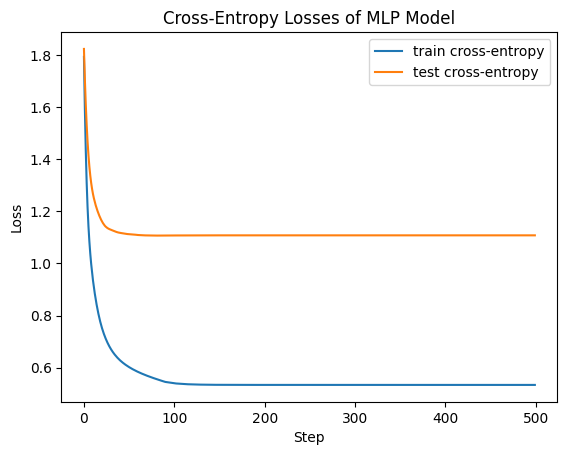

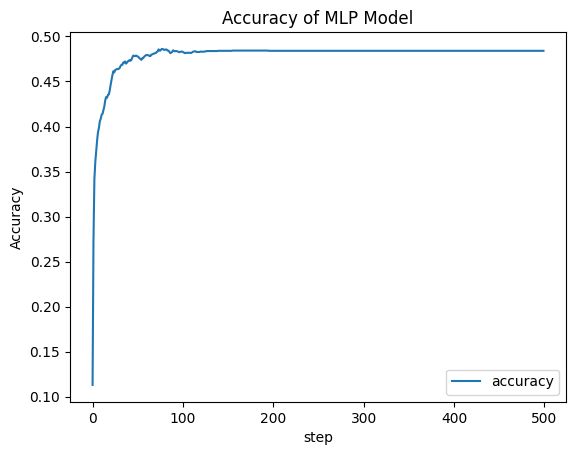

final MLP accuracy: 0.48407477140426636
final MLP training loss: 0.5340266227722168


In [66]:
plt.figure(1)
plt.plot(range(n_epochs_mlp), train_losses_mlp, label='train cross-entropy')
plt.plot(range(n_epochs_mlp), test_losses_mlp, label='test cross-entropy')
plt.title("Cross-Entropy Losses of MLP Model")

plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(2)
plt.plot(range(n_epochs_mlp), accuracies_mlp, label='accuracy')

plt.title("Accuracy of MLP Model")
plt.xlabel('step')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print(f"final MLP accuracy: {accuracies_mlp[-1]}")
print(f"final MLP training loss: {train_losses_mlp[-1]}")


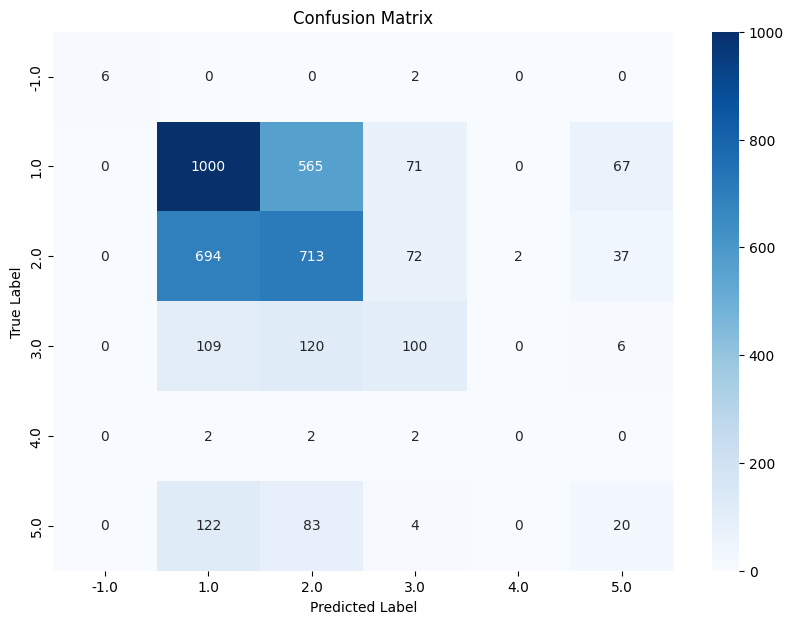

In [68]:
y_pred = test_outputs.argmax(dim=1).cpu().numpy()
y_pred = label_encoder.inverse_transform(y_pred) # unencode!
y_test_unencoded = label_encoder.inverse_transform(y_test)  # Use inverse_transform on true labels

# Compute the confusion matrix using the encoded labels
cm = confusion_matrix(y_test_unencoded, y_pred)

# Optionally, you can plot the confusion matrix with seaborn heatmap for better visualization
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Recommendations for Improvement
To improve the model's performance, several strategies can be implemented. First, enhancing the dataset's quality through feature engineering and additional relevant data sources could provide more context and improve predictions. Experimenting with hyperparameter tuning, such as adjusting the learning rate, batch size, or number of hidden layers, can refine the model's learning process. Additionally, exploring advanced optimization techniques like gradient clipping or learning rate scheduling may stabilize training and reduce loss fluctuations. Implementing class-specific techniques, such as focal loss, can address class imbalances observed in the confusion matrix. Furthermore, increasing regularization through higher dropout rates or L2 weight decay may help mitigate overfitting. Finally, exploring ensemble methods or pre-trained models for transfer learning could boost the model's generalization and accuracy while retaining computational efficiency.

### Ethical Considerations
There are quite a few ethical considerations about this model. Firstly, there is the presence of class imbalance in the dataset, raising concerns about bias, as the model may disproportionately favor the majority classes while underperforming on underrepresented ones, resulting in inaccurate or unfair predictions. 
The biggest ethical consideration, however, is a misuse of the model. Deploying this model without proper validation, oversight, or understanding of its limitations could lead to harm, especially in decision-making processes where human well-being is at stake. Of course, this model should never replace actual investigation when an accident occurs and any conclusion drawn by the model should always be investigated and validated by traditional means.